# <img src=".png" alt="Drawing" style="width:200px;"/>

# Price forecasts 
<h2 id="tocheading"> Table of Contents </h2>
<div id="toc"></div>

1. [Data & transformations](#data)
* [Stationarity tests & plots](#tests)
* [Model](#model)
* [Generating predictions](#forecasts)
* [Model backtesting](#backtesting)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rcParams
from dateutil.relativedelta import relativedelta

rcParams['figure.figsize'] = 10,8
import seaborn as sb
sb.set_style('white') #Style options are white grid, dark, white and ticks 

import datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 300)
pd.set_option('precision',2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [5]:
import warnings
warnings.filterwarnings("ignore")

## <a name='data'>  Data and transformations </a> 

In the file, ensure price is updated till last available month

In [29]:
train_end = '2015-05-01'

In [46]:
df = pd.read_csv('price_dummy.csv')
#pd.read_excel('',sheet_name='')#, header=1, usecols=range(8,13))

In [47]:
# Set the date as index 
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,price,prod2
0,2006-07-01,7.78,8.28
1,2006-08-01,7.65,7.02
2,2006-09-01,8.25,8.01
3,2006-10-01,8.39,7.77
4,2006-11-01,7.68,6.80


In [48]:
df.dtypes

Date     datetime64[ns]
price           float64
prod2           float64
dtype: object

In [49]:
df.set_index('Date', inplace=True)

In [50]:
# Remove future time periods (all data after train_end)
df = df.loc['2006-07-01':train_end,['price', 'prod2']]
df.tail()

,price,prod2
Date,,
2015-01-01,6.18,5.73
2015-02-01,5.88,5.11
2015-03-01,6.05,5.46
2015-04-01,6.78,5.93
2015-05-01,7.06,6.97


In [57]:
# Separate price out as a time series
df_price = df.loc['2006-07-01':train_end,['price']] # Only if more than one variable present

In [54]:
df_price

Date
2006-07-01   7.78
2006-08-01   7.65
2006-09-01   8.25
2006-10-01   8.39
2006-11-01   7.68
2006-12-01   6.37
2007-01-01   7.22
2007-02-01   8.11
2007-03-01   8.79
2007-04-01   8.53
2007-05-01   7.63
2007-06-01   9.55
2007-07-01   9.22
2007-08-01   7.81
2007-09-01   9.48
2007-10-01   7.64
2007-11-01   8.50
2007-12-01   8.67
2008-01-01   8.55
2008-02-01   7.80
2008-03-01   7.36
2008-04-01   7.10
2008-05-01   7.22
2008-06-01   7.79
2008-07-01   7.33
2008-08-01   7.38
2008-09-01   9.39
2008-10-01   8.34
2008-11-01   8.04
2008-12-01   9.07
             ... 
2012-12-01   7.95
2013-01-01   6.71
2013-02-01   7.43
2013-03-01   6.93
2013-04-01   8.01
2013-05-01   7.09
2013-06-01   6.31
2013-07-01   6.63
2013-08-01   7.14
2013-09-01   6.51
2013-10-01   6.07
2013-11-01   6.68
2013-12-01   6.00
2014-01-01   5.65
2014-02-01   6.71
2014-03-01   6.73
2014-04-01   6.64
2014-05-01   5.35
2014-06-01   5.67
2014-07-01   6.37
2014-08-01   6.75
2014-09-01   7.07
2014-10-01   6.22
2014-11-01   6.53
2014-

In [59]:
ts = df_price['price']
ts.head(4)

Date
2006-07-01   7.78
2006-08-01   7.65
2006-09-01   8.25
2006-10-01   8.39
Name: price, dtype: float64

## <a name='tests'> Stationarity tests & plots </a>

In [60]:
from statsmodels.tsa.stattools import adfuller

In [61]:
# If any correlations to explore
correlation = np.round(df['price'].corr(df['prod2']),2)

In [62]:
first_months = ['2007-01-01', '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01','2012-01-01', '2013-01-01','2014-01-01', '2015-01-01']

In [ ]:
month_names = ['Jan\'07', 'Jan\'08', 'Jan\'09', 'Jan\'10', 'Jan\'11', 'Jan\'12', 'Jan\'13', 'Jan\'14', 'Jan\'15']

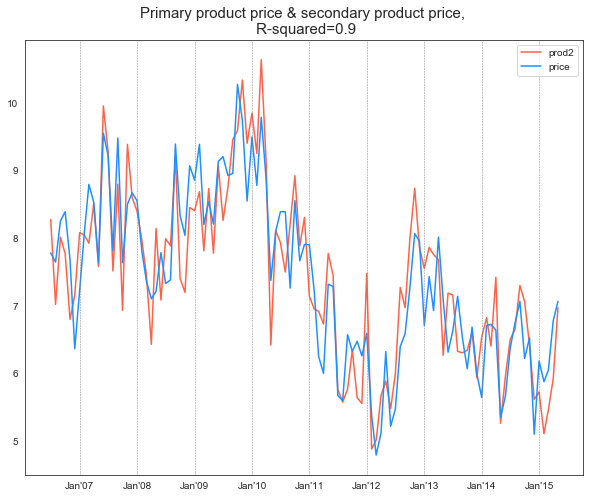

In [65]:
plt.plot(df['prod2'], color='TOMATO')
plt.plot(df['price'], color='dodgerblue')
plt.title('Primary product price & secondary product price, \n R-squared={}'.format(correlation), fontsize=15)
for date in first_months:
    plt.axvline(x=date, color='grey', linestyle='--', linewidth=0.5)
plt.xticks(first_months, labels=month_names)
plt.legend(loc='best');

Acid casein prices are volatile, but moves together with caseinate prices. 

Will keep entire casein price history. 

In [66]:
def stationarity_test(timeseries):
    # Rolling statistics 
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plots 
    plt.plot(timeseries, color='dodgerblue')
    plt.plot(rolmean, color='crimson', linestyle='--', label='12m Avg')
    plt.plot(rolstd, color='dimgray', label='12m Std', linestyle = ':')
    plt.title('{}: \n Rolling mean and standard deviation'.format(timeseries.name), fontsize = 15)
    for date in first_months:
        plt.axvline(x=date, color='grey', linestyle='--', linewidth=0.5)
    plt.xticks(first_months, labels=month_names)
    plt.legend(loc='best');
    
    # AD test
    dftest = adfuller(timeseries, autolag='AIC') 
    # Returns: adf, pvalue, usedlag, nobs, critical values, icbest, resstore
    df_output = pd.Series(dftest[0:4], index=['Test statistic', 'p-value', 'Lags used', 'No. of obs'])
    # Appending critical values to the df_output series 
    for item, value in dftest[4].items():
        df_output['Critical value (%s)'%item] = value
    print(timeseries.name)
    print(df_output)

price
Test statistic          -1.96
p-value                  0.30
Lags used                2.00
No. of obs             104.00
Critical value (1%)     -3.49
Critical value (5%)     -2.89
Critical value (10%)    -2.58
dtype: float64


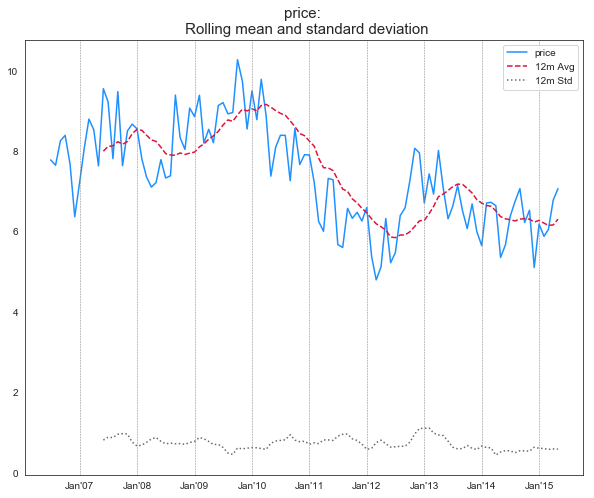

In [67]:
stationarity_test(ts)

We don't reject the hypothesis of a stationary series because:
* Mean does not display a consistent upward/downward trend
* Test stat is less than the critical value 

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose

Using additive model because it seems that the trend is linear and the seasonality seems constant over time 

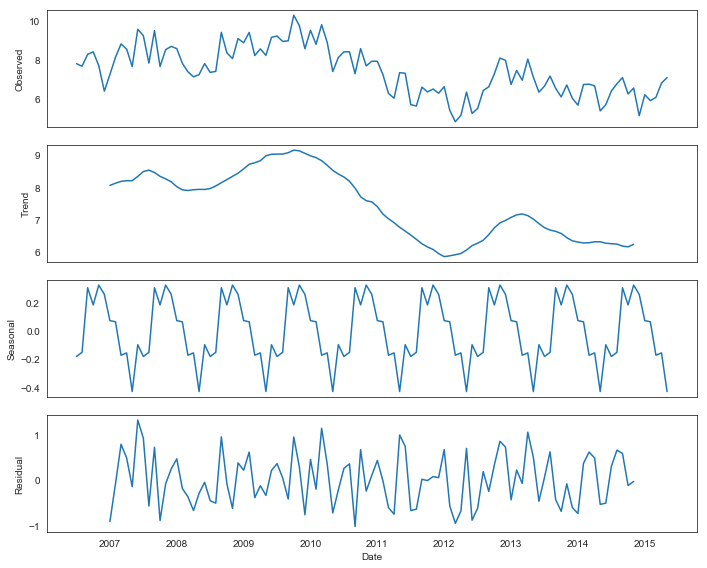

In [69]:
result = seasonal_decompose(ts, model='additive')
result.plot();
# for date in first_months:
#         plt.axvline(x=date, color='grey', linestyle='--', linewidth=0.5)
# plt.xticks(first_months, labels=month_names);
# plt.legend(loc='best');;

We have a time series with a seasonal component. What about the ACF and PACF on this

In [70]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

In [71]:
ts_acf = acf(ts, nlags=20)
ts_pacf = pacf(ts, nlags=20, method='ols')

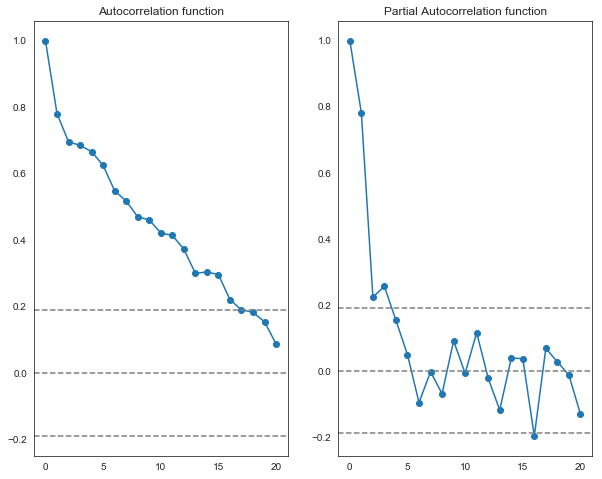

In [72]:
plt.subplot(121) # Plot in 1st pane of a 1x2 plot matrix
plt.plot(ts_acf, marker='o')
plt.axhline(y=0, linestyle="--", color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)), linestyle="--", color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)), linestyle="--", color='gray')
plt.title('Autocorrelation function');

plt.subplot(122) # Plot in 1st pane of a 1x2 plot matrix
plt.plot(ts_pacf, marker='o')
plt.axhline(y=0, linestyle="--", color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)), linestyle="--", color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)), linestyle="--", color='gray')
plt.title('Partial Autocorrelation function');

Slow decay in ACF indicates persistence. Requires trend removal. 

Lets detrend by taking first difference.

In [73]:
ts_diff = ts - ts.shift(1) # Subtract casein price each period from previous

In [74]:
ts_diff.name = 'Price first difference'

In [34]:
np.abs(4.71e-06) < np.abs(-2.58e+00)

True

Price first difference
Test statistic          -8.88
p-value                  0.00
Lags used                2.00
No. of obs             103.00
Critical value (1%)     -3.50
Critical value (5%)     -2.89
Critical value (10%)    -2.58
dtype: float64


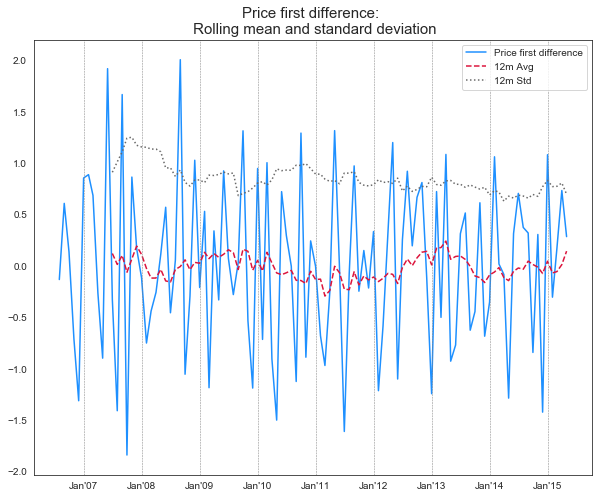

In [75]:
stationarity_test(ts_diff.dropna(inplace=False))

* The differenced series varies slightly but there is no trend overall 
* The test statistics are greater than critical values, so we reject the null of stationarity

Also deseasonalizing to understand the impact on stationarity (Note: Results didnt improve. We only do differencing finally) 

Price deseasoned
Test statistic         -2.67
p-value                 0.08
Lags used               5.00
No. of obs             89.00
Critical value (1%)    -3.51
Critical value (5%)    -2.89
Critical value (10%)   -2.58
dtype: float64


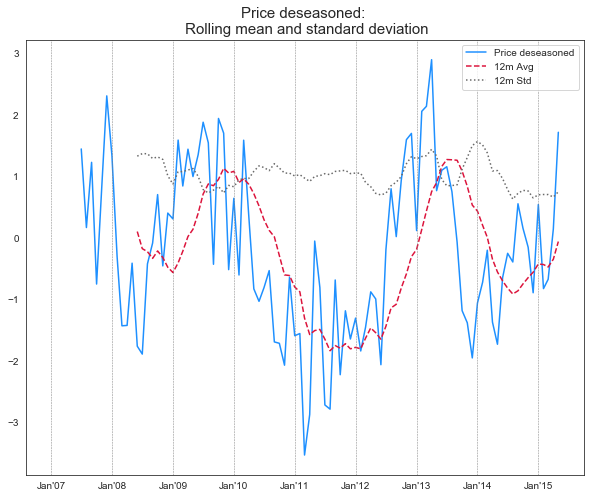

In [76]:
ts_deseasoned = ts - ts.shift(12)
ts_deseasoned.name = 'Price deseasoned'
stationarity_test(ts_deseasoned.dropna(inplace=False))

The critical value is isnide the 95% interval. 

Taking a first difference of the seasonal difference

Price deseasoned & differenced
Test statistic         -9.21
p-value                 0.00
Lags used               2.00
No. of obs             91.00
Critical value (1%)    -3.50
Critical value (5%)    -2.89
Critical value (10%)   -2.58
dtype: float64


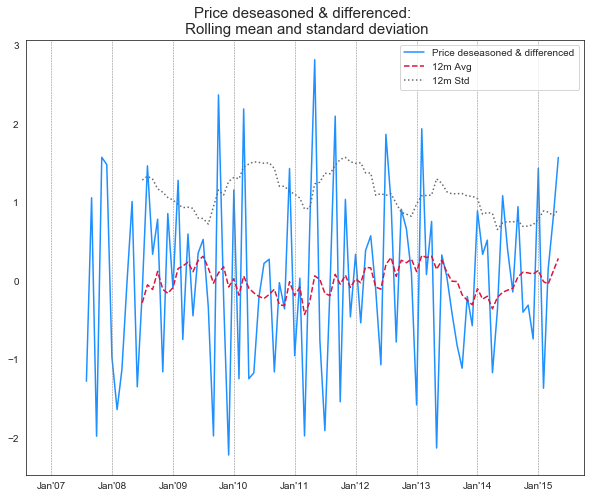

In [77]:
ts_deseasoned_diff = ts_diff - ts_diff.shift(12)
ts_deseasoned_diff.name = 'Price deseasoned & differenced'
stationarity_test(ts_deseasoned_diff.dropna(inplace=False))

Test statistic is still not greater than 99% critical value 

Of all three, simply differencing the data works best (minimal seasonality effect)

Lets view the ACF and PACF of the differenced series to determine the order of ARIMA 

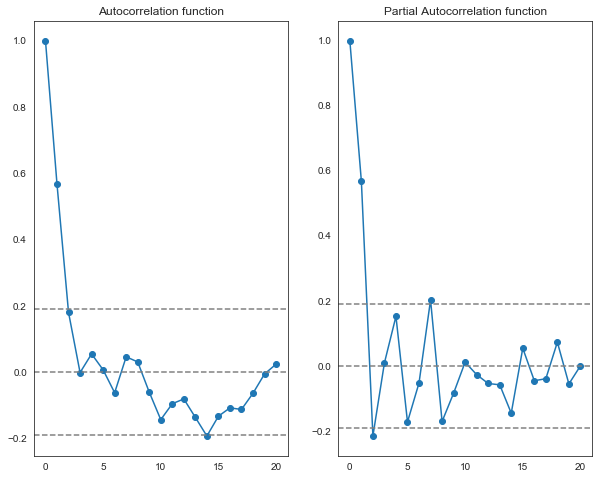

In [131]:
diff_acf = acf(ts_diff.dropna(), nlags = 20)
diff_pacf = pacf(ts_diff.dropna(), nlags=20, method='ols')

plt.subplot(121) # Plot in 1st pane of a 1x2 plot matrix
plt.plot(diff_acf, marker='o')
plt.axhline(y=0, linestyle="--", color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)), linestyle="--", color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)), linestyle="--", color='gray')
plt.title('Autocorrelation function');

plt.subplot(122) # Plot in 1st pane of a 1x2 plot matrix
plt.plot(diff_pacf, marker='o')
plt.axhline(y=0, linestyle="--", color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)), linestyle="--", color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)), linestyle="--", color='gray')
plt.title('Partial Autocorrelation function');

## <a name='model'> Acid casein model </a>

**ARIMA(2,1,2) model** i.e. p=2, d=1, q=2

In [8]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

In [9]:
model_212 = ARIMA(ts, order=(2,1,2))
results_212 = model_212.fit() # Fit the model

In [10]:
results_212.params

const            -0.01
ar.L1.D.Casein   -0.27
ar.L2.D.Casein   -0.17
ma.L1.D.Casein    1.01
ma.L2.D.Casein    0.73
dtype: float64

In [11]:
# the fitted values are the DIFFERENCES, not ACTUAL PRICES 
pred_arima_diff = pd.Series(results_212.fittedvalues, copy=True) 

In [13]:
plt.plot(ts_diff)
plt.plot(pred_arima_diff, color='red');
plt.title('RSS: %.4f'%sum(results_212.fittedvalues-ts_diff.dropna())**2);

NameError: name 'ts_diff' is not defined

In [14]:

print(pred_arima_diff.head())

Date
2010-08-01   -0.01
2010-09-01   -0.11
2010-10-01    0.11
2010-11-01   -0.14
2010-12-01   -0.19
dtype: float64


We need to compare actual prices to predicted prices (not predicted differences).
To go from predicted differences to predicted prices, we need to: 
1. Make a column containing cumulative sum of the differences 
* If forecasts start from index 1, add the cumulative difference to the index 0 (base) price 

In [12]:
# Find the cumulative sum. THis is to be added to the base value to arrive at forecasts  
pred_arima_diff_cumsum = pred_arima_diff.cumsum()
print(pred_arima_diff_cumsum.head())

Date
2010-08-01   -0.01
2010-09-01   -0.12
2010-10-01   -0.01
2010-11-01   -0.15
2010-12-01   -0.34
dtype: float64


In [13]:
# add the deltas to base values 
preds_arima_base = pd.Series(ts.iloc[0], index=ts.index)
preds_arima_base.head()

Date
2010-07-01   6.80
2010-08-01   6.80
2010-09-01   6.80
2010-10-01   6.80
2010-11-01   6.80
dtype: float64

In [14]:
preds_arima = preds_arima_base.add(pred_arima_diff_cumsum, fill_value=0)
preds_arima.head()

Date
2010-07-01   6.80
2010-08-01   6.79
2010-09-01   6.68
2010-10-01   6.79
2010-11-01   6.65
dtype: float64

Now lets plot the historical predictions against casein actuals 

Text(0.5, 1.0, 'Avg historical MAPE: 1.401')

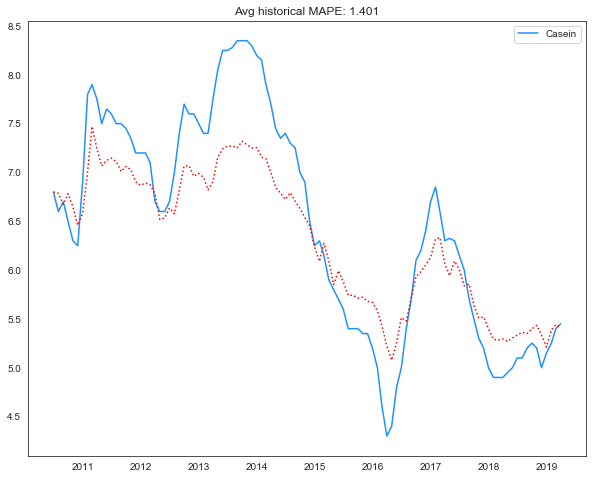

In [147]:
plt.plot(ts, color='dodgerblue')
plt.plot(preds_arima, color='red', linestyle=':')
plt.legend(loc='best')
plt.title('Avg historical MAPE: %.3f'%(np.mean((ts-preds_arima)*100/ts)))
# plt.legend();

However we need to do a train-validation test to evaluate the model. This is in [model backtesting](#backtesting) section

## <a name='forecasts'> Generating forecasts </a>

**Predict the price differences**

In [15]:
future_pred_diff = results_212.predict(start='2019-06-01', end='2020-01-01')
future_pred_diff

2019-06-01    0.04
2019-07-01   -0.04
2019-08-01   -0.01
2019-09-01   -0.01
2019-10-01   -0.01
2019-11-01   -0.01
2019-12-01   -0.01
2020-01-01   -0.01
Freq: MS, dtype: float64

**Cumulate the price differences**

In [16]:
future_pred_diff_cumsum = future_pred_diff.cumsum()
future_pred_diff_cumsum

2019-06-01    0.04
2019-07-01   -0.00
2019-08-01   -0.02
2019-09-01   -0.02
2019-10-01   -0.04
2019-11-01   -0.05
2019-12-01   -0.06
2020-01-01   -0.07
Freq: MS, dtype: float64

In [17]:
future_pred_base = pd.Series(ts[train_end], index=future_pred_diff.index)
future_pred_base

2019-06-01   5.65
2019-07-01   5.65
2019-08-01   5.65
2019-09-01   5.65
2019-10-01   5.65
2019-11-01   5.65
2019-12-01   5.65
2020-01-01   5.65
Freq: MS, dtype: float64

In [20]:
future_pred_base = pd.Series(ts[train_end], index=future_pred_diff.index)
future_pred_base

2019-06-01   5.50
2019-07-01   5.50
2019-08-01   5.50
2019-09-01   5.50
2019-10-01   5.50
2019-11-01   5.50
Freq: MS, dtype: float64

**Add these to base month price to arrive at forecasts**

In [18]:
future_preds = future_pred_base.add(future_pred_diff_cumsum, fill_value=0)
future_preds

2019-06-01   5.69
2019-07-01   5.65
2019-08-01   5.63
2019-09-01   5.63
2019-10-01   5.61
2019-11-01   5.60
2019-12-01   5.59
2020-01-01   5.58
Freq: MS, dtype: float64

In [21]:
future_preds = future_pred_base.add(future_pred_diff_cumsum, fill_value=0)
future_preds

2019-06-01   5.47
2019-07-01   5.42
2019-08-01   5.42
2019-09-01   5.41
2019-10-01   5.39
2019-11-01   5.38
Freq: MS, dtype: float64

## <a name='backtesting'> Model backtesting </a>

In [88]:
month_list = ['2017-12-01', '2018-01-01', '2018-02-01','2018-03-01',
             '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
             '2018-08-01', '2018-09-01']

In [103]:
import datetime

In [151]:
master_preds = pd.DataFrame()

In [152]:
for mon in month_list:
    print("Subsetting casein data till ", mon)
    train_df = ts['2010-07-01':mon] # Subset training data
    test_df = ts[mon:] # Test data (till 7 months forward from train)
    test_df = test_df.iloc[1:8]
    model_212 = ARIMA(ts, order=(2,1,2))
    results_212 = model_212.fit()
    start = datetime.datetime.strptime(mon, "%Y-%m-%d") 
    date_list = [start + relativedelta(months=x) for x in range(1,8)]
    print('Test data starts at:', test_df.index[0])
    # Forecast the first difference for next 7 months
    forecast_diff = results_212.predict(start=test_df.index[0], end=test_df.index[6])
    # Find the cumulative sum. THis is to be added to the base value to arrive at forecasts 
    forecast_diff_cumsum = forecast_diff.cumsum()
    # add the deltas to base values 
    forecasts = pd.Series(train_df[len(train_df)-1], index=test_df.index) # The last avble training data point
    forecasts = forecasts.add(forecast_diff_cumsum, fill_value=0)
    time_df = pd.DataFrame(mon, columns=['Train End'], index = test_df.index)
    df = pd.concat([time_df, test_df, forecasts], axis=1)#, index = test_df.index)
    df.columns = ['Train End','Casein', 'Predicted']
    df['APE'] = 100*(df['Casein']-df['Predicted'])/df['Casein']
    df['MAPE'] = df['APE'].mean()
    print(df)
    master_preds = pd.concat([master_preds, df], axis=0)

Subsetting casein data till  2017-12-01
Test data starts at: 2018-01-01 00:00:00
             Train End  Casein  Predicted   APE  MAPE
Date                                                 
2018-01-01  2017-12-01    5.00       5.08 -1.57 -0.55
2018-02-01  2017-12-01    4.90       4.97 -1.44 -0.55
2018-03-01  2017-12-01    4.90       4.96 -1.29 -0.55
2018-04-01  2017-12-01    4.90       4.97 -1.53 -0.55
2018-05-01  2017-12-01    4.95       4.95  0.00 -0.55
2018-06-01  2017-12-01    5.00       4.98  0.31 -0.55
2018-07-01  2017-12-01    5.10       5.01  1.68 -0.55
Subsetting casein data till  2018-01-01
Test data starts at: 2018-02-01 00:00:00
             Train End  Casein  Predicted  APE  MAPE
Date                                                
2018-02-01  2018-01-01    4.90       4.89 0.16  1.42
2018-03-01  2018-01-01    4.90       4.88 0.31  1.42
2018-04-01  2018-01-01    4.90       4.90 0.08  1.42
2018-05-01  2018-01-01    4.95       4.87 1.59  1.42
2018-06-01  2018-01-01    5.00    

In [153]:
master_preds

,Train End,Casein,Predicted,APE,MAPE
Date,,,,,
2018-01-01,2017-12-01,5.00,5.08,-1.57,-0.55
2018-02-01,2017-12-01,4.90,4.97,-1.44,-0.55
2018-03-01,2017-12-01,4.90,4.96,-1.29,-0.55
2018-04-01,2017-12-01,4.90,4.97,-1.53,-0.55
2018-05-01,2017-12-01,4.95,4.95,0.00,-0.55
2018-06-01,2017-12-01,5.00,4.98,0.31,-0.55
2018-07-01,2017-12-01,5.10,5.01,1.68,-0.55
2018-02-01,2018-01-01,4.90,4.89,0.16,1.42
2018-03-01,2018-01-01,4.90,4.88,0.31,1.42


In [154]:
master_preds.to_csv('C:\\Users\\sridevi.tolety\\Desktop\\casein_preds.csv')